In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
sns.set_palette('Spectral_r')

In [3]:
train_path = "train.csv"
test_path =  "test.csv"

In [4]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [6]:
train.describe().T

,count,unique,top,freq
discourse_id,36765,36765,0013cc385424,1
essay_id,36765,4191,91B1F82B2CF1,23
discourse_text,36765,36691,Summer projects should be student-designed,14
discourse_type,36765,7,Evidence,12105
discourse_effectiveness,36765,3,Adequate,20977


In [7]:
test.describe().T

,count,unique,top,freq
discourse_id,10,10,a261b6e14276,1
essay_id,10,1,D72CB1C11673,10
discourse_text,10,10,Making choices in life can be very difficult. ...,1
discourse_type,10,5,Claim,4


In [8]:
train.head(25)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective


In [9]:
train.discourse_text

0        Hi, i'm Isaac, i'm going to be writing about h...
1        On my perspective, I think that the face is a ...
2        I think that the face is a natural landform be...
3        If life was on Mars, we would know by now. The...
4        People thought that the face was formed by ali...
                               ...                        
36760    For many people they don't like only asking on...
36761    also people have different views and opinions ...
36762    Advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

In [10]:
subset = train.essay_id.value_counts()
subset

91B1F82B2CF1    23
4CA37D113612    23
900A879708F0    23
A7EC6F462F8B    22
DECAE402BB38    22
                ..
AB02689C1A9B     1
FFFF80B8CC2F     1
377548575048     1
5E85F1FB4E22     1
9706F8E7D534     1
Name: essay_id, Length: 4191, dtype: int64

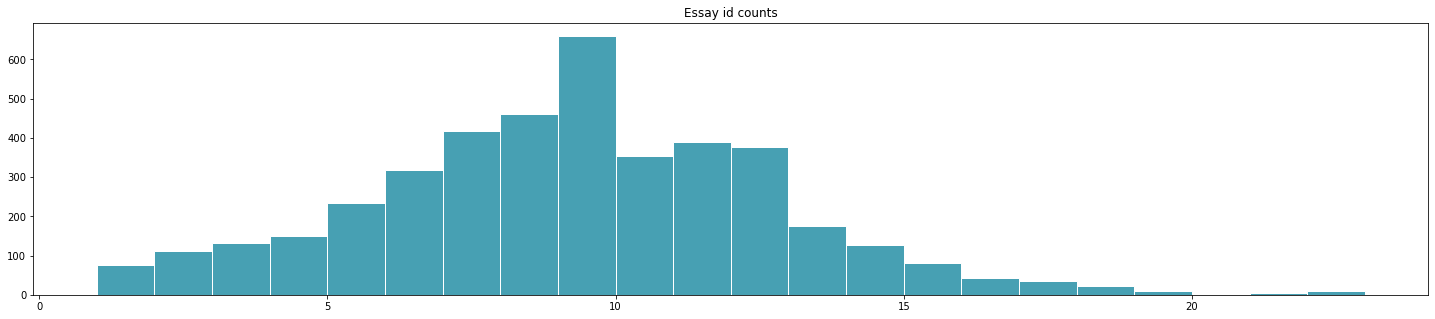

In [11]:
plt.figure(figsize = (25,5))
plt.hist(subset.values, rwidth = 1, bins = 22, align='mid', edgecolor = 'white')
plt.title('Essay id counts')
plt.show()

The majority of essays appear ~10 times.


In [12]:
subset = train.discourse_effectiveness.value_counts(ascending=True)
subset = subset / len(train)

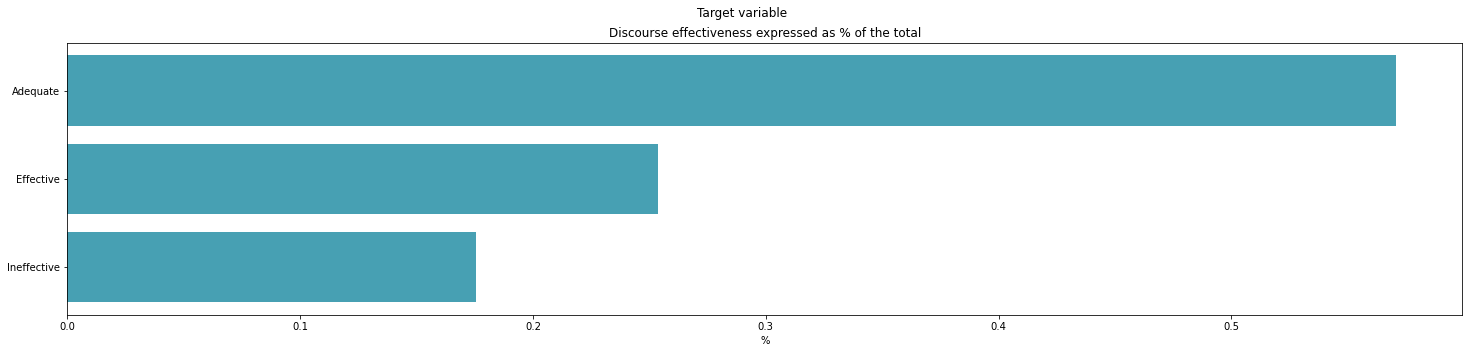

In [13]:
plt.figure(figsize = (25,5))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse effectiveness expressed as % of the total')
plt.suptitle('Target variable')
plt.xlabel('%')
plt.show()

So it it somewhat unbalanced.

In [14]:
len(train) - train.discourse_text.nunique() 

74

There are 74 instances where one or more _discourse_texts_ is repeated.

In [15]:
subset = train.discourse_type.value_counts(ascending=True)
subset = subset / len(train)

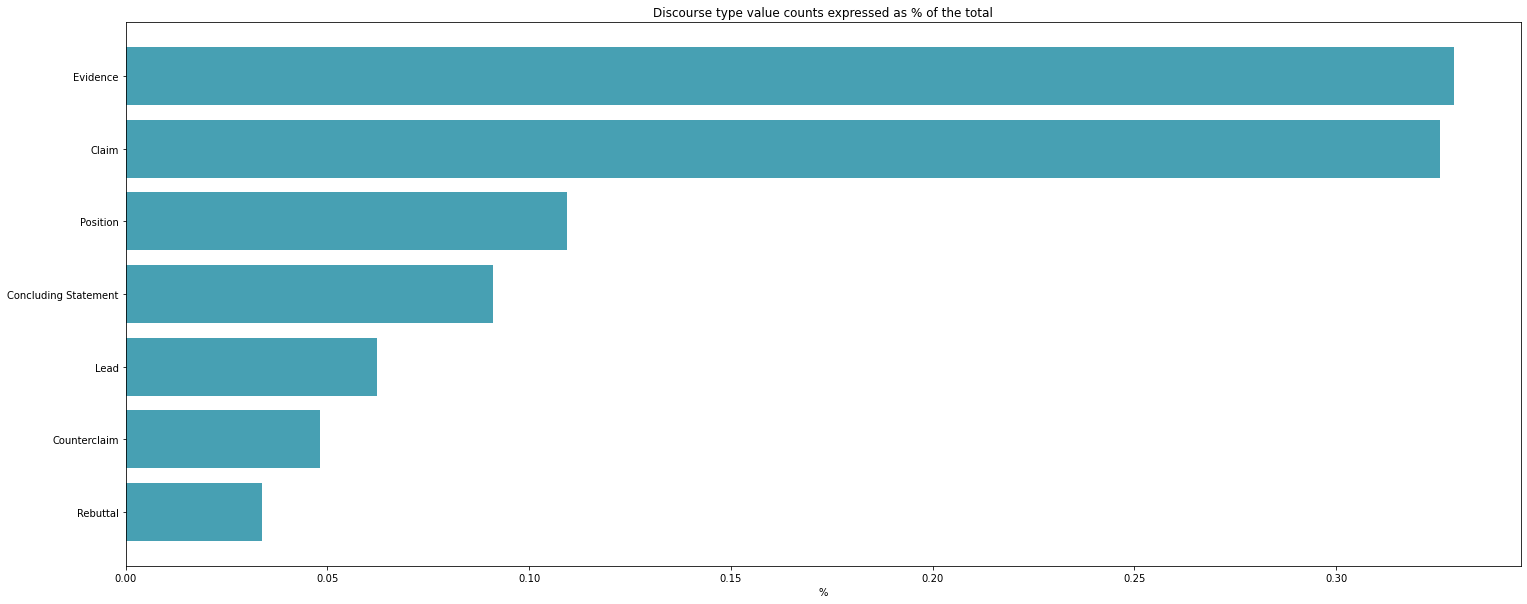

In [16]:
plt.figure(figsize = (25,10))
plt.barh(y = subset.index, width=subset.values)
plt.title('Discourse type value counts expressed as % of the total')
plt.xlabel('%')
plt.show()

In [17]:
subset = train.loc[train.discourse_effectiveness == 'Adequate'].discourse_type
subset = sorted(subset)

<AxesSubplot:ylabel='Count'>

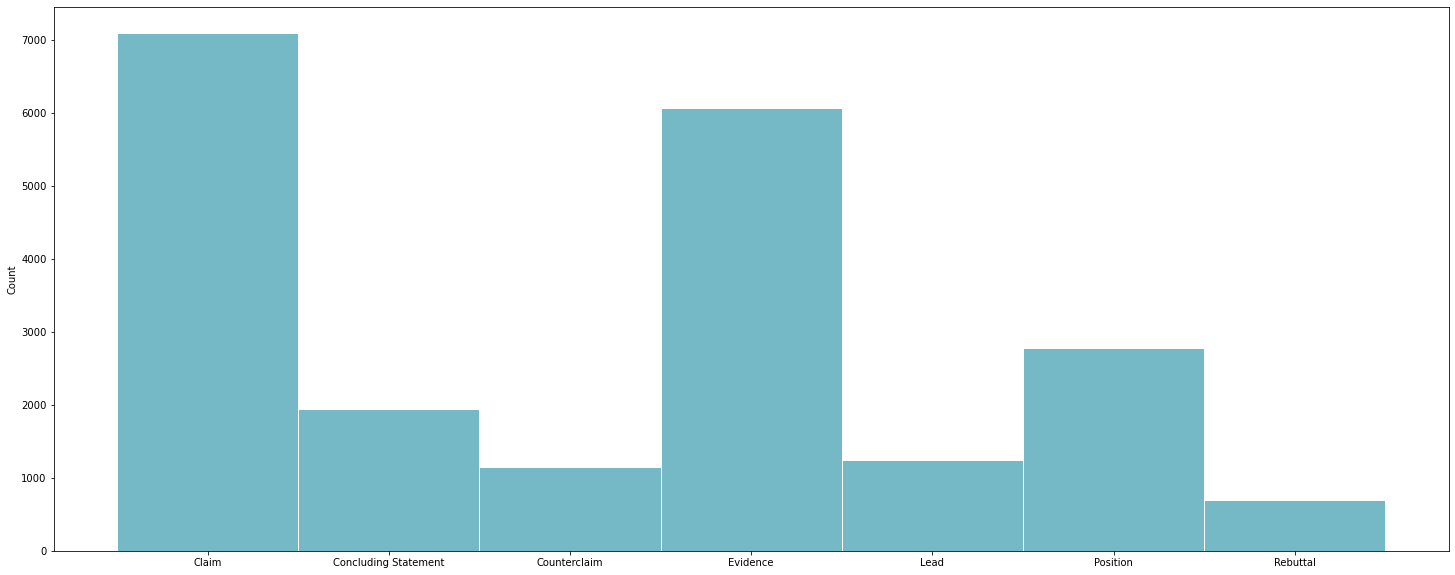

In [18]:
plt.figure(figsize = (25,10))
sns.histplot(subset, edgecolor = 'white')

In [19]:
subset = train.discourse_text.str.len()
subset

0        317
1        210
2        105
3        362
4        101
        ... 
36760    126
36761     57
36762    121
36763    439
36764     67
Name: discourse_text, Length: 36765, dtype: int64

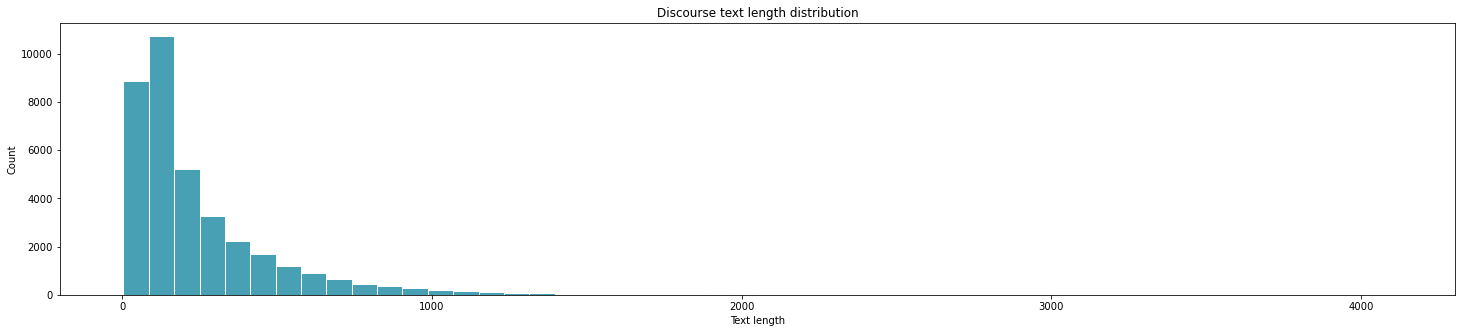

In [20]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text length distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

In [21]:
subset = train.discourse_text.str.split(' ').map(len)
subset

0        68
1        42
2        22
3        73
4        19
         ..
36760    22
36761    10
36762    24
36763    82
36764    12
Name: discourse_text, Length: 36765, dtype: int64

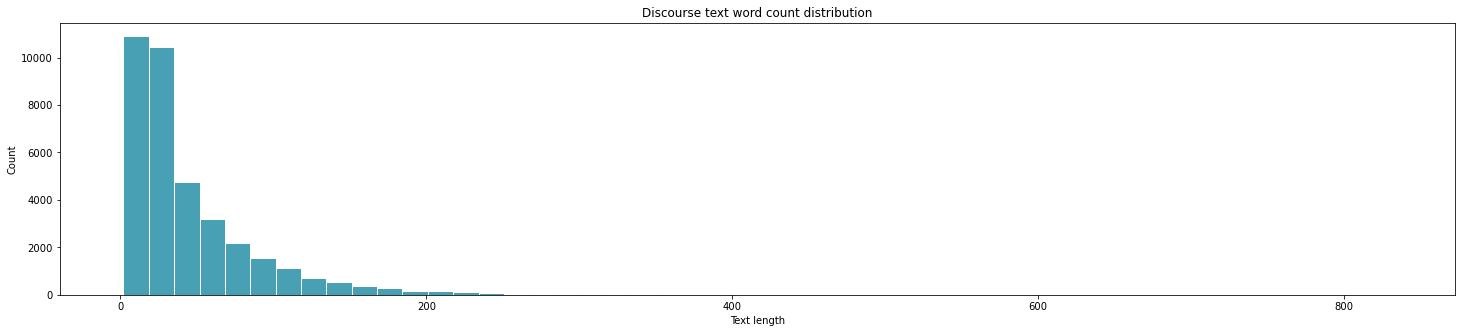

In [22]:
plt.figure(figsize = (25,5))
plt.hist(subset, bins = 50, edgecolor = 'white')
plt.title('Discourse text word count distribution')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

In [23]:
import spacy

2022-07-26 02:47:45.967535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 02:47:46.000932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-26 02:47:46.000947: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
